# NEST SIMULATION 
##### 1. IMPORTING RELEVANT DATA FROM SNUDDA GENERATED NEURON FILES:\
    a) Neuron Matrix: to keep the info of neuron types \
    b) Synaptic Matrix: Where each row has the info of [preID, posID] of one synapse \
    for now every synapse will have the same properties, no matter the types of neurons\
    (later we can add more info on this matrix that will help set the type of synapses used for each)\
    c*) (optional/not really relevant but already available) Positions: matrix with coordinates for each neuron position\
    d) Info about the input given to the neurons
##### 2) CREATING THE NEST NETWORK \
    a) Create the neurons (the correct # of neurons, in their posiiton*)\
    b) Connect the neurons (for loop with Synaptic Matrix as info)\
    c) Connect the measuring devices to the neurons in order to observe spiking and voltage \
    d) Create the spike generators to feed the input 
##### 3) RUN THE SIM
    

## 0. LIBRARIES

### 0.1 Regular Libraries

In [1]:
import nest
import matplotlib.pyplot as plt


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-3.1
 Built: Sep 28 2021 11:43:45

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



### 0.2 Functions created by me

In [2]:
from getData import *
from plot import *

## 1. IMPORTING DATA

In [3]:
positions_list = getNeuronPositions('net_100')

synaptic_matrix = getSynapses('net_100')

input_matrix = getInput('net_100', 100)

neuron_IDs = getNeuronMatrix('/home/ubuntu/BasalGanglia/NEURON-data/net_100')


## 2. CREATING THE NEST NETWORK

### 2.1 Creating the neurons

Here we create a position list, with the coordinates of each neuron of the network.
(This first step is not necessary, since the spatial distribution of the network does not influence the NEST simulation.)

In [4]:
pos = nest.spatial.free(positions_list) # using NEURON positions

**All the neurons have the same characteristics. They are all alpha conductance based integrate and fire model, with the default parameters of nest.**

In [5]:
s_nodes = nest.Create("iaf_cond_alpha", 99, positions=pos) 

### 2.2 Connecting the Network

In this version of the simulation **each connected pair has N synapses\*, and all synapses have a weight of -2**
With the info of the synaptic matrix, we create the pre-synaptic as post-synaptic neuron ID lists, and transform them into numpy arrays

\* N = the # corresponding to their connection on neuron

In [6]:
pre_list = []
pos_list = []

for i in range(0,len(synaptic_matrix)):
    pre_list.append(s_nodes[synaptic_matrix[i][0]])
    pos_list.append(s_nodes[synaptic_matrix[i][1]])
    
pre_array = np.transpose(np.array(pre_list)).flatten()
pos_array = np.transpose(np.array(pos_list)).flatten()

With the arrays ready, we can connect the synapses all in one command.

In [7]:
syn_wgt = np.full(len(pre_array), -2.0)
nest.Connect(pre_array,pos_array,conn_spec= "one_to_one", syn_spec= {"weight": syn_wgt})

In [10]:
connections = nest.GetConnections(s_nodes, s_nodes)
#nest.GetStatus(connections)

### 2.3 Creating the Input 
Now onto the creation of the Spike Generators. **The synapses between the input neurons and the ones on the network all have a weight of 10**

In [11]:
inputs = nest.Create("spike_generator", 99)

In [12]:
for g, generator in enumerate(inputs):
    nest.SetStatus(generator, {"spike_times": input_matrix[g]})

In [13]:
input_syn_wgt = np.full(len(inputs), 10.0)
nest.Connect(inputs,s_nodes, conn_spec= "one_to_one", syn_spec={"weight": input_syn_wgt})


Nov 15 14:58:48 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.


### 2.4 Creating the Recording Devices

In [14]:
spikerecorder = nest.Create("spike_recorder")

In [15]:
nest.Connect(s_nodes,spikerecorder, conn_spec= "all_to_all")

In [16]:
multimeter = nest.Create("multimeter")
multimeter.set(record_from=["V_m"])
nest.Connect(multimeter,s_nodes, "all_to_all")

In [17]:
mult1 = nest.Create("multimeter", 5)
mult1.set(record_from=["V_m"])
chosen_nodes = [1,11,21,31,41]
nest.Connect(mult1,chosen_nodes, "one_to_one")

## 3. RUNNING THE SIMULATION
Here we are using a total run itme of 2000 ms (and the default step of simulation of 0.1 ms)

In [18]:
nest.Simulate(2000.0)


Nov 15 14:59:13 NodeManager::prepare_nodes [Info]: 
    Preparing 205 nodes for simulation.

Nov 15 14:59:13 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 205
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Nov 15 14:59:15 SimulationManager::run [Info]: 
    Simulation finished.


### ANALYSING THE RESULTS

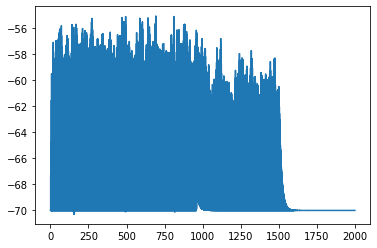

In [19]:
dmm = multimeter.get()
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]
ids = dmm["events"]["senders"]

plt.figure(1)
plt.plot(ts, Vms)
plt.show()

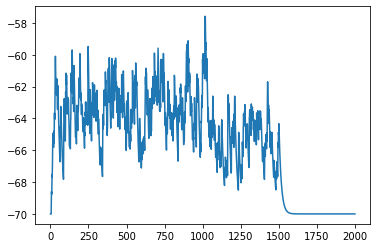

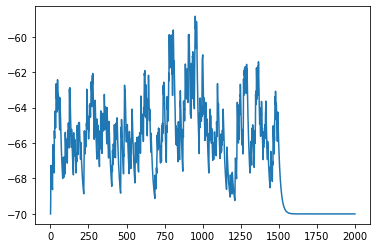

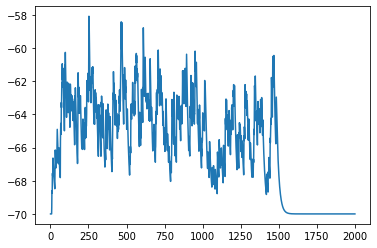

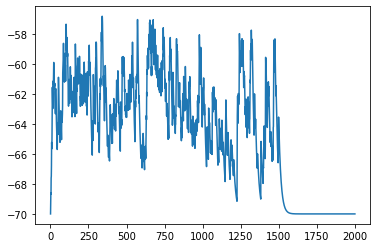

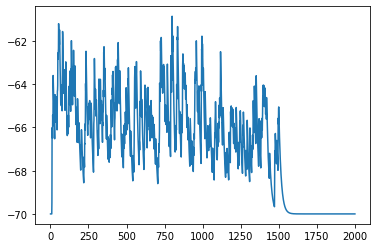

In [20]:
for i in range(0,5):
    dmm1 = mult1[i].get()
    Vms1 = dmm1["events"]["V_m"]
    ts1 = dmm1["events"]["times"]
    ids1 = dmm1["events"]["senders"]

    plt.figure(1)
    plt.plot(ts1, Vms1)
    plt.show()

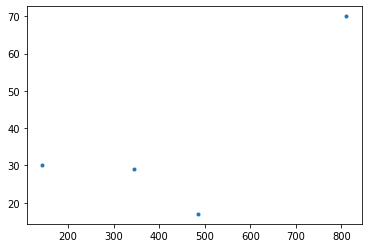

In [21]:
dSD = spikerecorder.get("events")
evs = dSD["senders"]
ts = dSD["times"]
plt.figure(2)
plt.plot(ts, evs, ".")
plt.show()

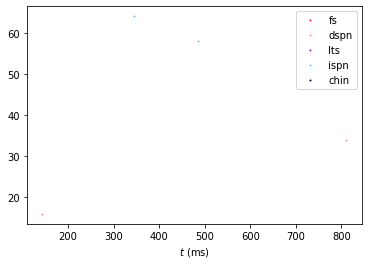

In [22]:
spikes = {}

for i in range(0, len(evs)) :

    nID = evs[i]
    spike_time = ts[i]
    if(nID not in spikes.keys()):
        spikes[nID] = []            
    spikes[nID].append(spike_time)

for i in range(0, 100):
    if(i not in spikes.keys()):
        spikes[i] = []

chin_color='xkcd:dark blue'
ispn_color='xkcd:sky blue'
lts_color='xkcd:violet'
dspn_color='xkcd:pink'
fs_color='xkcd:hot pink'

n_ids = np.array(list(spikes.keys()), dtype=int)
n_ids.sort() #organize the neurons by id

dspn_ID, ispn_ID, lts_ID, fs_ID, chin_ID = getNeuronSubMatrixes(neuron_IDs)

orderedIDs = getOrderedIDs(dspn_ID, ispn_ID, lts_ID, fs_ID, chin_ID)


fig_handle = plt.figure()
ax = fig_handle.add_subplot(111)
ax.set_xlabel('$t$ (ms)')

plotSpikes(spikes, fs_ID, orderedIDs, fs_color, 'fs', ax)
plotSpikes(spikes, dspn_ID, orderedIDs,dspn_color, 'dspn', ax)
plotSpikes(spikes, lts_ID, orderedIDs, lts_color, 'lts', ax)
plotSpikes(spikes, ispn_ID, orderedIDs,ispn_color , 'ispn', ax)
plotSpikes(spikes, chin_ID, orderedIDs, chin_color, 'chin', ax)

plt.legend()
plt.show()

### OTHERS

In [ ]:
help(nest.Models)